# Simulation of liquid butane

## Preliminaries

Import the Python packages we'll need, and initialise a simulation with 250 chains and 4 beads per chain (butane). By default we create only a single replica with index 1. Note that because the model code is written in Fortran internally, replicas, chains and bead indices are 1-based not zero-based. 

In [1]:
import numpy as np  # Numpy
import math as m    # Maths

import hs_alkane as mdl   # Fortran library we'll used to model the alkane chain

In [2]:
Nbeads  = 4    # Butane
Nchains = 250  # 250 chains in chain.xmol

# Initialise the simulation box and alkane module ready to hold chains
mdl.box_initialise()             
mdl.alkane_set_nbeads(Nbeads)    
mdl.alkane_set_nchains(Nchains)  
mdl.alkane_initialise() 

## Visualisation functions

These are handy for creating visualisations of the system configuration via the ASE ngl viewer. Some bashing of units and colourscheme is needed to get useful output.

In [3]:
from ase import Atoms
from ase.visualize import view

def mk_ase_config(ibox, Nbeads, Nchains):
    'Uses the current state of the alkane model to construct an ASE atoms object'
    
    # Create and populate ASE object
    model_positions = np.empty([Nchains*Nbeads, 3])
    cell_vectors = mdl.box_get_cell(ibox)
   
    for ichain in range(0, Nchains):
        model_positions[Nbeads*ichain:Nbeads*ichain+Nbeads] = mdl.alkane_get_chain(ichain+1, ibox)
    
    confstring = "C"+str(Nbeads*Nchains)
    
    box_config = Atoms(confstring, positions=model_positions*(1.5/0.4), pbc=True, cell=cell_vectors*(1.5/0.4)) 

    # If we want to wrap all beads inside the box
    box_config.wrap()
    
    return box_config  # Returns ASE atom object
    
def vis_chains(vis_config):
    '''Takes an ASE atoms object or list thereof and creates a customised ngl viewer 
       with appropriate settings for our bulk alkane chain models'''
    
    met = 0.35
    rad = 1.0
    
    colours = ['#FF1111','#FFAAAA', '#DDDDDD', '#1111FF', '#AAAAFF']
    ncols = len(colours)
    
    sel=list()
    for icol in range(ncols):
        sel.append(list())
    
    # Create lists for each colour
    for ichain in range(0, Nchains):
        icol = ichain%ncols
        for ibead in range(Nbeads):
            iatom = ichain*Nbeads + ibead
            sel[icol].append(iatom)
            
    v = view(vis_config, viewer='ngl')                   
    v.view.clear_representations()
    v.view.add_representation('unitcell', color='#000000')
    
    for icol in range(ncols):
        v.view.add_representation('ball+stick', selection=sel[icol], color=colours[icol], radius=rad, metalness=met)

    return v

## Generate random initial configuration

This is a bit of a cludge and should probably be replaced with a routine in inside the library.

In [5]:
boxsize = 15.0  # Initial size of cubic box
ibox = 1
cell_vectors = np.array([[boxsize,0.0,0.0],[0.0,boxsize,0.0],[0.0,0.0,boxsize]])
mdl.box_set_cell(ibox, cell_vectors)

# Don't use link cells when making new chains
mdl.box_set_bypass_link_cells(1)
mdl.box_set_use_verlet_list(0)

ncopy = Nchains
for ichain in range(ncopy):
    mdl.alkane_set_nchains(ichain+1)  # Only calculate using this and previous chains
    rb_factor = 0.0
    while rb_factor < 0.001:
        rb_factor, ifail = mdl.alkane_grow_chain(ichain+1, ibox, 1) # Third arg indicates new chain required
        if ifail!=0:
            rb_factor = 0.0
        
        
# By default we have periodic boundary conditions, and the example below benefits from using link cells
# to speed up computation. These can be disabled (and will be automatically if the system is too small for them)
# or we can specify that we want to use a Verlet neighbour list instead. If using the neighbour list then we 
# need to make sure if is updated appropriately after moving beads around.

#mdl.box_set_use_verlet_list(1)        
mdl.box_set_link_cell_length(1.5)
mdl.box_set_bypass_link_cells(0)
mdl.box_construct_link_cells(ibox)
mdl.alkane_construct_linked_lists(ibox)

In [6]:
# Visualise initial configuration
ase_config = mk_ase_config(1, Nbeads, Nchains)
vis_chains(ase_config)

### Sanity check initial configuration

Functions are provided to check that the configuration obeys the model constraints on bond lengths/angles and doesn't contain any forbidden dihedral angles. We also check that no beads overlap, other than those which are allowed to in the model, e.g. first and second nearest neighbours along a chain.

In [7]:
# Loop over chains and sanity check configuration
ibox = 1
for ichain in range(0, Nchains):
    
    # Checks if internal geometry of chain (bonds/angles) are consistent with the model
    geom_flag = mdl.alkane_check_chain_geometry(ichain+1, ibox)
    if geom_flag != 0:
        print("Incorrect geometry for chain ",ichain)
       
    
# Checks if beads on any two chains overlap
overlap_flag = mdl.alkane_check_chain_overlap(ibox)
if overlap_flag != 0:
    print("Overlaps between chains in configuration")
else:
    print("No overlaps between chains found in configuration")  

No overlaps between chains found in configuration


## Monte Carlo loop

Example NPT simulation with anisotropic box moves. First query the maximum changes made when we ask the model to make one of the various trial move types. We will use translation, rotation, dihedral and box moves.

In [8]:
# Report move parameters
print("Maximum translation displacement:", mdl.alkane_get_dr_max())
print("Maximum rotation angle: ", mdl.alkane_get_dt_max())
print("Maximum dihedral change: ", mdl.alkane_get_dh_max())
print("Maximum cell vector displacement: ",mdl.alkane_get_dv_max())

Maximum translation displacement: 0.012
Maximum rotation angle:  0.07
Maximum dihedral change:  0.06
Maximum cell vector displacement:  0.003


These defaults are intended for simulating a crystal. They will result in nearly all moves being accepted in our low density random configuration, so we'll make them bigger. We also want to make isotropic volume moves rather than changes in random components of a cell vector.

In [9]:
mdl.alkane_set_dr_max(0.65)
mdl.alkane_set_dt_max(0.43)
mdl.alkane_set_dh_max(0.4)

mdl.box_set_isotropic(1)
mdl.alkane_set_dv_max(0.5)

The following code implements a simple NPT simulation using these moves.

In [12]:
# For progress bar
from ipywidgets import IntProgress
from IPython.display import display

# Move types
move_types = ['box','translate', 'rotate', 'dihedral']
ivol = 0; itrans = 1; irot = 2; idih = 3;
moves_attempted = np.zeros(4)
moves_accepted  = np.zeros(4)

# Use the one and only simulation box
ibox = 1

# Initialise counters
Nsweeps = 5000
isweep = 0

# Create progress bar
f = IntProgress(min=0, max=Nsweeps) 
display(f) # display the bar

# Set pressure
pressure = 0.2

# Visualisation snapshots
vis_snapshots = list()
vis_interval = 100

# How often to sample quantities
sample_interval = 10
samples = list()

# In case we're using Verlet lists rather than link cells
mdl.alkane_construct_neighbour_list(ibox)

# Initialise timer
t1 = mdl.timer_init()

# Loop over the number of MC sweeps to perform
while isweep < Nsweeps:
    
    # One "sweep" is usually interpretted as one attempt to change each degree of freedom on average once.
    # here we have 3 translation + 2 rotation + 1 internal degrees of freedom per chain, plus 1 degree
    # of freedom for the simulation cell (isotropic volume moves).
    
    # A box move changes 1 degree of freedom
    # A chain translation move changes 3 degrees of freedom
    # A chain rotation move changes 2 degrees of freedom
    # A dihedral angle move changes 1 degree of freedom
    
    # Hence if we attempt each move type with a probability proportional to the number of degrees
    # of freedom it changes, we need to do 2*Nchains+(1/3) moves to get one "sweep". Sampling in this
    # ratio isn't necessarily optimal, but it's a good starting point.
    
    # Calculate cumulative move ratios used to decide move type
    total_deg = 6*Nchains+1

    box_move_prob   = 1.0/total_deg
    trans_move_prob = box_move_prob   + 3.0*Nchains/total_deg
    rot_move_prob   = trans_move_prob + 2.0*Nchains/total_deg
    dih_move_prob   = rot_move_prob   + 1.0*Nchains/total_deg 
    
    # Loop over move attempts at the current sweep
    imove = 0
    while imove < 2*Nchains+1:

        #==========================#
        # Make a random trial move #
        #==========================#
        
        # Pick a random chain numbered from 0 to Nchains
        ichain = np.random.randint(0, high=Nchains)

        # Backup old chain positions. Note that whenever we call a routine inside the
        # hs_alkane library we need to add one to the bead/chain index to account for
        # Fortran indexing. 
        current_chain = mdl.alkane_get_chain(ichain+1, ibox)
        backup_chain = current_chain.copy() # Note copy, not equivalence

        # Pick a move type at random and call the appropriate function to make that 
        # trial move and return the corresponding ratio of Boltzmann factors.
        xi = np.random.random()
        if xi < box_move_prob:
            # Attempt a volume move
            itype = ivol
            boltz = mdl.alkane_box_resize(pressure, ibox, 0) # 0 indicates not a reset to previous box
        elif xi < trans_move_prob:
            # Attempt a translation move
            itype = itrans
            boltz = mdl.alkane_translate_chain(ichain+1, ibox)
        elif xi < rot_move_prob:
            # Attempt a rotation move
            itype = irot
            boltz, quat = mdl.alkane_rotate_chain(ichain+1, ibox, 0) # 0 indicates not rotating around a bond
        else:
            # Attempt a dihedreal angle move
            itype = idih
            boltz, bead1, angle = mdl.alkane_bond_rotate(ichain+1, ibox, 1) # 1 indicates flips allowed
        
        # Increment attempted move counter
        moves_attempted[itype] += 1
        
        #====================#
        # Accept/reject move #
        #====================#
        
        # Reject according to Metropolis criterion
        if (np.random.random() < boltz):
            
            # Move accepted
            moves_accepted[itype] += 1
            
            # Update linked-list for new positions if not volume move. 
            if (itype!=ivol):
                new_chain = mdl.alkane_get_chain(ichain+1, ibox).copy()
                for ibead in range(Nbeads):
                    mdl.alkane_update_linked_lists(ibead+1, ichain+1, ibox, backup_chain[ibead], new_chain[ibead])
                    
        else:
            
            # Reject move
            if (itype!=ivol):
                # Restore old chain if single chain move
                for ibead in range(Nbeads):
                    current_chain[ibead] = backup_chain[ibead]
            else:
                # Reset the box change - special fucntion for this.
                dumboltz = mdl.alkane_box_resize(pressure, ibox, 1) # 1 indicates reset to old box

        imove += 1
        
    # Store ASE atoms shapshots at interval vis_interval        
    if isweep%vis_interval == 0:
        vis_snapshots.append(mk_ase_config(ibox,Nbeads, Nchains))
        
    # Sample 
    if isweep%sample_interval == 0:
        samples.append(mdl.box_compute_volume(ibox))
    
    # Increment sweep counter and progress bar
    isweep += 1
    f.value += 1
    
    
# Timing
print("Completed ",Nsweeps," sweeps in ",mdl.timer_elapsed_time()," seconds.")
    
# Report statistics
for itype in range(4):
    percent = 100.0 * moves_accepted[itype]/moves_attempted[itype]
    print("Accepted ",percent," % of ",move_types[itype]," moves")
    

IntProgress(value=0, max=5000)

Completed  5000  sweeps in  77.46500000000378  seconds.
Accepted  97.60335530257639  % of  box  moves
Accepted  66.21381392610063  % of  translate  moves
Accepted  94.5949898994743  % of  rotate  moves
Accepted  49.065242639399415  % of  dihedral  moves


### Visualisation and analysis

N.B. the method I'm using to visualise here doesn't seem to update the unit cell at each frame which is a bit annoying. 

In [13]:
# Visualise simulation snapshots
vis_chains(vis_snapshots)

In [14]:
# Rerun the sanity check to make sure nothing went wrong
overlap_flag = mdl.alkane_check_chain_overlap(ibox)
if overlap_flag != 0:
    print("Overlaps between chains in configuration")
else:
    print("No overlaps between chains found in configuration")

No overlaps between chains found in configuration


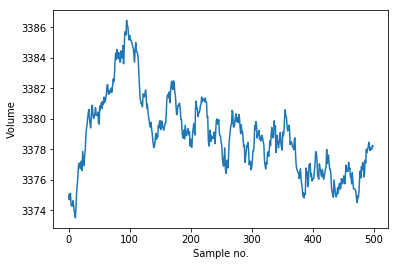

In [18]:
# Plot volume samples
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(samples)
plt.xlabel('Sample no.')
plt.ylabel('Volume')
plt.show()

This indicates we've reached some kind of equilibrium?